# Model Traning

### Imports

In [3]:
import numpy as np 
import pandas as pd 
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from gensim.models import Word2Vec
from gensim.models import FastText

### loading w2v and fasttext models

In [7]:
w2v = Word2Vec.load('models/w2v/word2vac_vector_size=100_window=7_min_count=5_sg=1_epochs=15_workers=4.model')
w2v.wv.most_similar("good")

[('great', 0.8438117504119873),
 ('well', 0.7960057258605957),
 ('excellent', 0.7909898161888123),
 ('decent', 0.7712104916572571),
 ('think', 0.7426007986068726),
 ('pretty', 0.7399470806121826),
 ('like', 0.7283840179443359),
 ('okay', 0.7239789962768555),
 ('fine', 0.7231138348579407),
 ('bad', 0.7200161814689636)]

In [25]:
ft = FastText.load('models/FastText/FastText_vector_size=100_window=7_min_count=5_sg=1_epochs=15_workers=4.model')
ft.wv.most_similar("good")

[('great', 0.8385777473449707),
 ('well', 0.8175740242004395),
 ('excellent', 0.7854905128479004),
 ('think', 0.7670866250991821),
 ('decent', 0.7608587741851807),
 ('probably', 0.7406277060508728),
 ('fine', 0.7378620505332947),
 ('pretty', 0.7362132668495178),
 ('nice', 0.7332591414451599),
 ('ok', 0.7276937961578369)]

In [26]:
pad_vec = np.load('embeddings/pad_vec.npy')
oov_vec = np.load('embeddings/oov_vec.npy') 
def get_ft_padded_embeddings(sentence, max_words):
    model = ft
    embedding_dim = model.vector_size
    embeddings = []
    
    for word in sentence:
        embeddings.append(model.wv[word])

    # tuncate
    if len(embeddings) > max_words:
        embeddings = embeddings[:max_words]
    # paddinf
    else:
        while len(embeddings) < max_words:
            embeddings.append(pad_vec)

    return np.array(embeddings)

## Logistic regression

In [2]:
from sklearn.linear_model import LogisticRegression

### Tfid

In [3]:
chunksize = 10000
tfid_lr_metrics_list = []
tfid_lr = LogisticRegression(max_iter=1000)

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):

    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_lr.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_lr.predict(X_val)
    y_prob = tfid_lr.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_lr_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_lr_metrics_df = pd.DataFrame(tfid_lr_metrics_list)
print(tfid_lr_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [02:51, 171.15s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [05:50, 176.10s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [08:45, 175.38s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [11:41, 175.69s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [14:37, 175.44s/it]


   batch  accuracy  precision    recall        f1   auc_roc  \
0      0  0.759680   0.769863  0.745358  0.757412  0.828406   
1      1  0.716488   0.718571  0.689986  0.703989  0.784847   
2      2  0.695973   0.715470  0.677124  0.695769  0.757975   
3      3  0.702429   0.715517  0.672065  0.693111  0.771746   
4      4  0.721045   0.736296  0.696078  0.715623  0.794311   

           confusion_matrix  rows_dropped  
0  [[576, 168], [192, 562]]            17  
1  [[566, 197], [226, 503]]            57  
2  [[519, 206], [247, 518]]            72  
3  [[543, 198], [243, 498]]           120  
4  [[524, 178], [217, 497]]           143  


In [5]:
tfid_lr_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_lr_metrics_df['rows_dropped'].sum()

(accuracy     0.719123
 precision    0.731144
 recall       0.696122
 f1           0.713181
 auc_roc      0.787457
 dtype: float64,
 409)

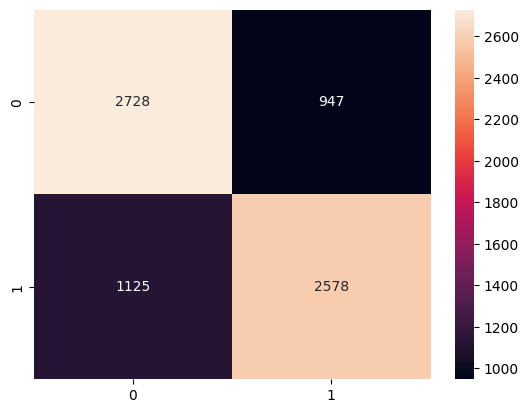

In [11]:
sns.heatmap(tfid_lr_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

### Tfid

In [13]:
chunksize = 10000
tfid_rf_metrics_list = []
tfid_rf = RandomForestClassifier()

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_rf.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_rf.predict(X_val)
    y_prob = tfid_rf.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_rf_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_rf_metrics_df = pd.DataFrame(tfid_rf_metrics_list)
print(tfid_rf_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [03:27, 207.02s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [07:16, 220.32s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [11:02, 222.72s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [14:45, 223.06s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [18:16, 219.32s/it]


   batch  accuracy  precision    recall        f1   auc_roc  \
0      0  0.759012   0.775596  0.733422  0.753920  0.826637   
1      1  0.731903   0.742984  0.689986  0.715505  0.774950   
2      2  0.702685   0.709635  0.712418  0.711024  0.744081   
3      3  0.702429   0.718023  0.666667  0.691393  0.756141   
4      4  0.733051   0.736620  0.732493  0.734551  0.778346   

           confusion_matrix  rows_dropped  
0  [[584, 160], [201, 553]]            17  
1  [[589, 174], [226, 503]]            57  
2  [[502, 223], [220, 545]]            72  
3  [[547, 194], [247, 494]]           120  
4  [[515, 187], [191, 523]]           143  


In [14]:
tfid_rf_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_rf_metrics_df['rows_dropped'].sum()

(accuracy     0.725816
 precision    0.736572
 recall       0.706997
 f1           0.721278
 auc_roc      0.776031
 dtype: float64,
 409)

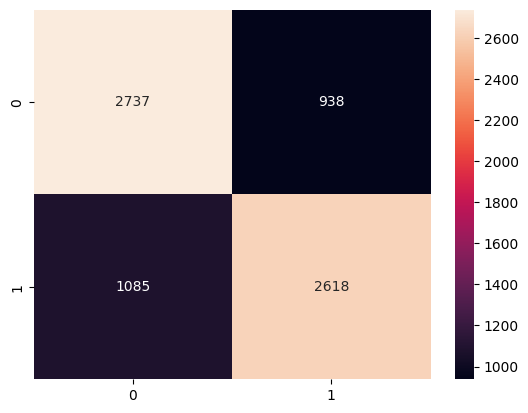

In [15]:
sns.heatmap(tfid_rf_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## Gausian NB

In [3]:
from sklearn.naive_bayes import GaussianNB

### Tfid

In [4]:
chunksize = 10000
tfid_gnb_metrics_list = []
tfid_gnb = GaussianNB()

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_gnb.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_gnb.predict(X_val)
    y_prob = tfid_gnb.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_gnb_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_gnb_metrics_df = pd.DataFrame(tfid_gnb_metrics_list)
print(tfid_gnb_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [02:13, 133.66s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [04:39, 140.61s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [07:06, 143.70s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [09:35, 145.85s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [11:56, 143.29s/it]


   batch  accuracy  precision    recall        f1   auc_roc  \
0      0  0.550734   0.553080  0.559682  0.556361  0.552927   
1      1  0.497319   0.485021  0.466392  0.475524  0.498330   
2      2  0.483221   0.496706  0.492810  0.494751  0.485209   
3      3  0.514170   0.513981  0.520918  0.517426  0.514609   
4      4  0.502825   0.506831  0.519608  0.513140  0.498832   

           confusion_matrix  rows_dropped  
0  [[403, 341], [332, 422]]            17  
1  [[402, 361], [389, 340]]            57  
2  [[343, 382], [388, 377]]            72  
3  [[376, 365], [355, 386]]           120  
4  [[341, 361], [343, 371]]           143  


In [5]:
tfid_gnb_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_gnb_metrics_df['rows_dropped'].sum() 

(accuracy     0.509654
 precision    0.511124
 recall       0.511882
 f1           0.511440
 auc_roc      0.509981
 dtype: float64,
 409)

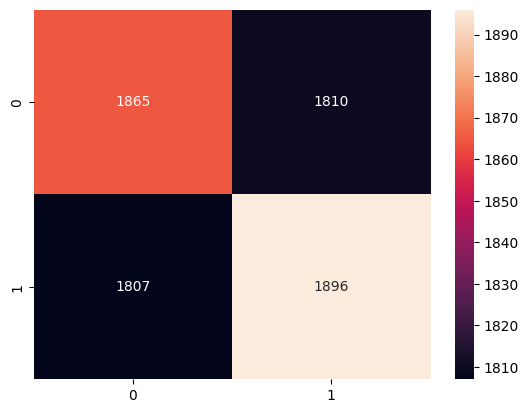

In [6]:
sns.heatmap(tfid_gnb_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## BernoulliNB

In [1]:
from sklearn.naive_bayes import BernoulliNB

### Tfid

In [4]:
chunksize = 10000
tfid_bnb_metrics_list = []
tfid_bnb = BernoulliNB()

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_bnb.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_bnb.predict(X_val)
    y_prob = tfid_bnb.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_bnb_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_bnb_metrics_df = pd.DataFrame(tfid_bnb_metrics_list)
print(tfid_bnb_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [02:46, 166.53s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [05:34, 167.32s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [08:23, 168.01s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [11:19, 171.25s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [13:57, 167.42s/it]


   batch  accuracy  precision    recall        f1   auc_roc          confusion_matrix  rows_dropped
0      0  0.607477   0.614325  0.591512  0.602703  0.640421  [[464, 280], [308, 446]]            17
1      1  0.491287   0.478134  0.449931  0.463604  0.498730  [[405, 358], [401, 328]]            57
2      2  0.485235   0.498667  0.488889  0.493729  0.491963  [[349, 376], [391, 374]]            72
3      3  0.520243   0.523585  0.449393  0.483660  0.520790  [[438, 303], [408, 333]]           120
4      4  0.490819   0.495449  0.533613  0.513823  0.504545  [[314, 388], [333, 381]]           143


In [5]:
tfid_bnb_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_bnb_metrics_df['rows_dropped'].sum() 

(accuracy     0.519012
 precision    0.522032
 recall       0.502668
 f1           0.511504
 auc_roc      0.531290
 dtype: float64,
 409)

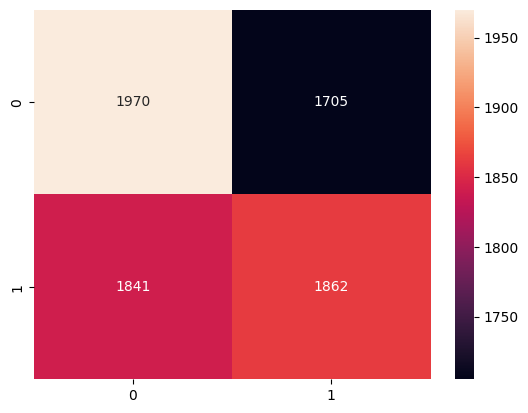

In [6]:
sns.heatmap(tfid_bnb_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## ComplementNB

In [8]:
from sklearn.naive_bayes import ComplementNB

### Tfid

In [9]:
chunksize = 10000
tfid_cnb_metrics_list = []
tfid_cnb = ComplementNB()

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_cnb.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_cnb.predict(X_val)
    y_prob = tfid_cnb.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_cnb_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_cnb_metrics_df = pd.DataFrame(tfid_cnb_metrics_list)
print(tfid_cnb_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [02:40, 160.13s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [05:45, 175.13s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [08:37, 173.68s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [11:29, 173.04s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [15:43, 188.76s/it]


   batch  accuracy  precision    recall        f1   auc_roc          confusion_matrix  rows_dropped
0      0  0.759680   0.761968  0.759947  0.760956  0.822711  [[565, 179], [181, 573]]            17
1      1  0.717828   0.704787  0.727023  0.715733  0.778844  [[541, 222], [199, 530]]            57
2      2  0.703356   0.710013  0.713725  0.711864  0.756600  [[502, 223], [219, 546]]            72
3      3  0.699730   0.696286  0.708502  0.702341  0.775782  [[512, 229], [216, 525]]           120
4      4  0.733051   0.725806  0.756303  0.740741  0.796033  [[498, 204], [174, 540]]           143


In [10]:
tfid_cnb_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_cnb_metrics_df['rows_dropped'].sum() 

(accuracy     0.722729
 precision    0.719772
 recall       0.733100
 f1           0.726327
 auc_roc      0.785994
 dtype: float64,
 409)

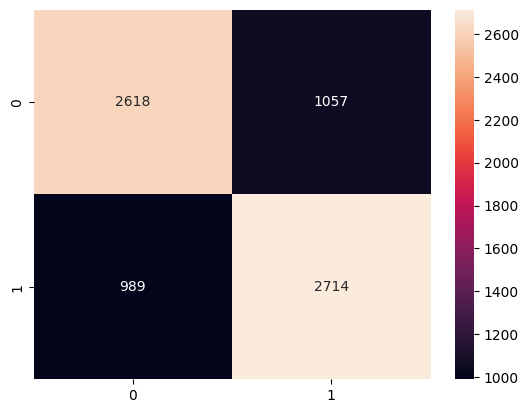

In [11]:
sns.heatmap(tfid_cnb_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## SGDClassifier

In [12]:
from sklearn.linear_model import SGDClassifier

### Tfid

In [14]:
chunksize = 10000
tfid_sgdc_metrics_list = []
tfid_sgdc = SGDClassifier(loss='log_loss')

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_sgdc.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_sgdc.predict(X_val)
    y_prob = tfid_sgdc.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_sgdc_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_sgdc_metrics_df = pd.DataFrame(tfid_sgdc_metrics_list)
print(tfid_sgdc_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [04:00, 240.71s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [08:19, 251.33s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [12:33, 252.50s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [15:57, 233.40s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [19:12, 230.42s/it]


   batch  accuracy  precision    recall        f1   auc_roc          confusion_matrix  rows_dropped
0      0  0.686248   0.633208  0.895225  0.741758  0.790130   [[353, 391], [79, 675]]            17
1      1  0.712466   0.678571  0.781893  0.726577  0.790102  [[493, 270], [159, 570]]            57
2      2  0.681879   0.656284  0.798693  0.720519  0.751176  [[405, 320], [154, 611]]            72
3      3  0.631579   0.857143  0.315789  0.461538  0.746828   [[702, 39], [507, 234]]           120
4      4  0.655367   0.846626  0.386555  0.530769  0.766444   [[652, 50], [438, 276]]           143


In [15]:
tfid_sgdc_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_sgdc_metrics_df['rows_dropped'].sum() 

(accuracy     0.673508
 precision    0.734366
 recall       0.635631
 f1           0.636232
 auc_roc      0.768936
 dtype: float64,
 409)

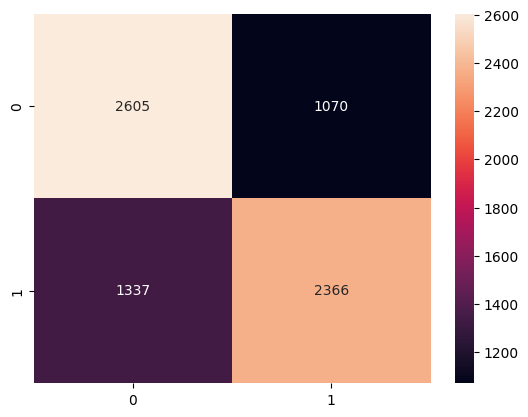

In [16]:
sns.heatmap(tfid_sgdc_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## GradientBoostingClassifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

### Tfid

In [18]:
chunksize = 10000
tfid_gbc_metrics_list = []
tfid_gbc = GradientBoostingClassifier()

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_gbc.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_gbc.predict(X_val)
    y_prob = tfid_gbc.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_gbc_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_gbc_metrics_df = pd.DataFrame(tfid_gbc_metrics_list)
print(tfid_gbc_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [09:01, 541.51s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [17:54, 536.41s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [26:51, 536.95s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [35:41, 534.04s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [44:13, 530.78s/it]


   batch  accuracy  precision    recall        f1   auc_roc          confusion_matrix  rows_dropped
0      0  0.767023   0.766798  0.771883  0.769332  0.844073  [[567, 177], [172, 582]]            17
1      1  0.740617   0.747826  0.707819  0.727273  0.802564  [[589, 174], [213, 516]]            57
2      2  0.722148   0.727038  0.734641  0.730819  0.776569  [[514, 211], [203, 562]]            72
3      3  0.706478   0.717330  0.681511  0.698962  0.789237  [[542, 199], [236, 505]]           120
4      4  0.743644   0.754717  0.728291  0.741269  0.812708  [[533, 169], [194, 520]]           143


In [19]:
tfid_gbc_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_gbc_metrics_df['rows_dropped'].sum() 

(accuracy     0.735982
 precision    0.742742
 recall       0.724829
 f1           0.733531
 auc_roc      0.805030
 dtype: float64,
 409)

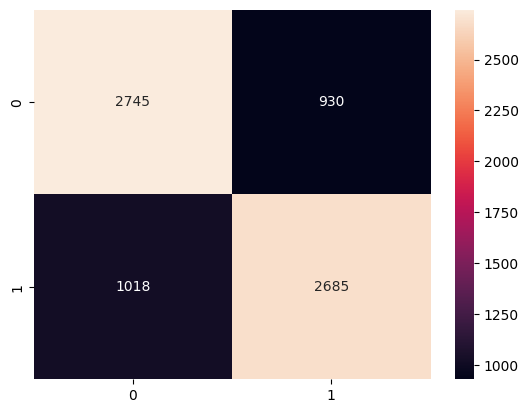

In [20]:
sns.heatmap(tfid_gbc_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()

## KNeighborsClassifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier

### Tfid

In [22]:
chunksize = 10000
tfid_knn_metrics_list = []
tfid_knn = KNeighborsClassifier()

for i, chunk in enumerate(tqdm(pd.read_csv('dataset/preped/tfid_df.csv', dtype='float32', chunksize=chunksize))):
    # Count initial rows
    initial_rows = len(chunk)

    # Drop rows where target is NaN
    chunk = chunk.dropna(subset=['sentiment_LE'])

    # Count dropped rows
    dropped_rows = initial_rows - len(chunk)
    if dropped_rows > 0:
        print(f"Batch {i}: Dropped {dropped_rows} rows due to NaN target.")

    # Drop target column and replace infs / NaNs in features
    y = chunk['sentiment_LE']
    X = chunk.drop(columns=['sentiment_LE'])
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    if len(X) == 0:
        print(f"Batch {i} is empty after cleaning. Skipping.")
        continue

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Fit model
    tfid_knn.fit(X_train, y_train)

    # Predictions
    y_pred = tfid_knn.predict(X_val)
    y_prob = tfid_knn.predict_proba(X_val)[:, 1]

    # Compute metrics
    batch_metrics = {
        'batch': i,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc_roc': roc_auc_score(y_val, y_prob),
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'rows_dropped': dropped_rows
    }

    tfid_knn_metrics_list.append(batch_metrics)

# Convert to DataFrame
tfid_knn_metrics_df = pd.DataFrame(tfid_knn_metrics_list)
print(tfid_knn_metrics_df)

0it [00:00, ?it/s]

Batch 0: Dropped 17 rows due to NaN target.


1it [04:01, 241.39s/it]

Batch 1: Dropped 57 rows due to NaN target.


2it [06:54, 201.14s/it]

Batch 2: Dropped 72 rows due to NaN target.


3it [09:52, 190.62s/it]

Batch 3: Dropped 120 rows due to NaN target.


4it [12:47, 184.53s/it]

Batch 4: Dropped 143 rows due to NaN target.


5it [15:40, 188.04s/it]


   batch  accuracy  precision    recall        f1   auc_roc          confusion_matrix  rows_dropped
0      0  0.722296   0.730245  0.710875  0.720430  0.785260  [[546, 198], [218, 536]]            17
1      1  0.690349   0.690442  0.663923  0.676923  0.746587  [[546, 217], [245, 484]]            57
2      2  0.683893   0.692913  0.690196  0.691552  0.733072  [[491, 234], [237, 528]]            72
3      3  0.669366   0.671683  0.662618  0.667120  0.737394  [[501, 240], [250, 491]]           120
4      4  0.714689   0.717087  0.717087  0.717087  0.753741  [[500, 202], [202, 512]]           143


In [23]:
tfid_knn_metrics_df[['accuracy', 'precision', 'recall', 'f1', 'auc_roc']].mean(), tfid_knn_metrics_df['rows_dropped'].sum() 

(accuracy     0.696119
 precision    0.700474
 recall       0.688940
 f1           0.694622
 auc_roc      0.751211
 dtype: float64,
 409)

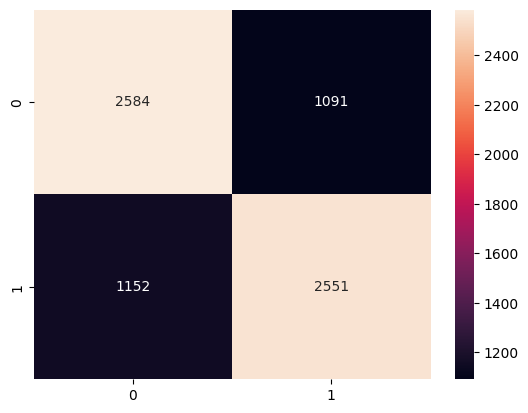

In [24]:
sns.heatmap(tfid_knn_metrics_df['confusion_matrix'].sum(), annot=True, fmt='.0f')
plt.show()